# Кластеризация
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[HSE][ML][MS][HW02] <ФИО>`, где вместо `<ФИО>` указаны фамилия и имя__

В этом домашнем задании предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы, а так же применить один из алгоритмов к задаче уменьшения цветности изображения.

In [1]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons, make_swiss_roll
import numpy as np
from scipy.spatial import distance_matrix as build_distance
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import cv2
import collections
from typing import NoReturn

In [2]:
def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

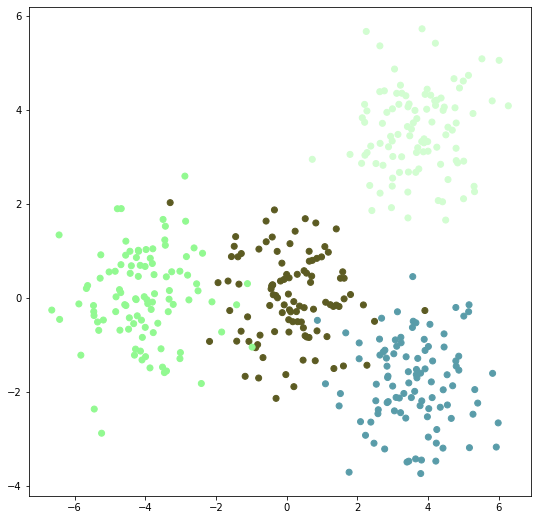

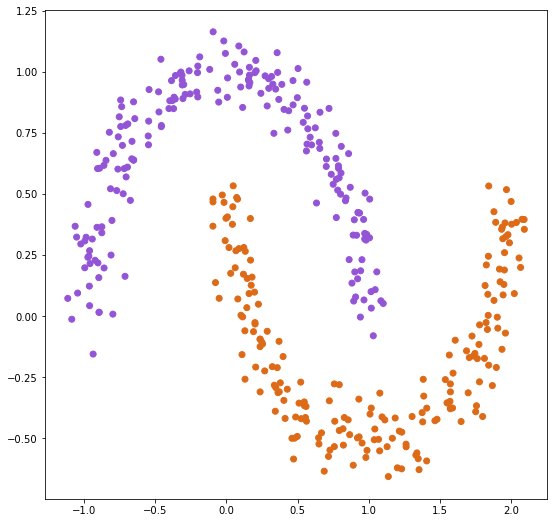

In [3]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels)
X_2, true_labels = make_moons(400, noise=0.075)
visualize_clasters(X_2, true_labels)

### Задание 1 (3 балла)
Первый метод, который предлагается реализовать - метод K средних.

#### Описание методов
`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

#### Инициализация кластеров
Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++

__Не забудте реинициализировать пустые кластеры!__

In [4]:
class KMeans:
    def __init__(self, n_clusters: int, init: str = "random",
                 max_iter: int = 300):
        """

        Parameters
        ----------
        n_clusters : int
            Число итоговых кластеров при кластеризации.
        init : str
            Способ инициализации кластеров. Один из трех вариантов:
            1. random --- центроиды кластеров являются случайными точками,
            2. sample --- центроиды кластеров выбираются случайно из  X,
            3. k-means++ --- центроиды кластеров инициализируются
                при помощи метода K-means++.
        max_iter : int
            Максимальное число итераций для kmeans.

        """
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = None

    def _init_centroids(self, X: np.array):
        """

        Инициализирует self.centroids центроиды кластеров для X с помощью метода, указанного в self.init.
         Вызывается однажды, на старте обучения.

        Parameters
        ----------
        X : np.array
            Набор данных, на основе которого инициализируются центроиды.

        """

        n_points, n_features = X.shape
        if self.init == "random":
            lower_bounds = np.min(X, axis=0)
            upper_bounds = np.max(X, axis=0)
            self.centroids = np.random.uniform(low=lower_bounds, high=upper_bounds, size=(4, n_features))
        elif self.init == "sample":
            self.centroids = X[np.random.choice(n_points, 4, replace=False), :]
        elif self.init == "k-means++":
            centroids = np.zeros((self.n_clusters, n_features), dtype=X.dtype)
            centroids[0] = X[np.random.randint(n_points)]  # first centroid
            for i in range(1, self.n_clusters):
                distances = np.array([np.linalg.norm(X - c, axis=1) for c in centroids[:i, :]]).transpose()
                closest_distances = np.min(distances, axis=1)
                cum_sum_distances = np.cumsum(closest_distances)
                rand_val = np.random.random() * np.sum(closest_distances)
                best_candidate_idx = np.searchsorted(cum_sum_distances, v=rand_val, side='right')
                best_candidate_idx = min(max(best_candidate_idx, 0), cum_sum_distances.size - 1)
                centroids[i] = X[best_candidate_idx]
            self.centroids = centroids
        else:
            raise NotImplementedError()

    def fit(self, X: np.array, y=None) -> NoReturn:
        """
        Ищет и запоминает в self.centroids центроиды кластеров для X.

        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit обязаны принимать
            параметры X и y, даже если y не используется).

        """
        n_points, n_features = X.shape
        if self.n_clusters > n_points:
            raise ValueError("The number of clusters must be less than the number of points.")

        self._init_centroids(X)
        labels = np.argmin(np.array([np.linalg.norm(X - center, axis=1)
                                     for center in self.centroids]).transpose(), axis=1)

        for iteration in range(1, self.max_iter + 1):
            labels_prev = labels
            self.centroids = np.zeros((self.n_clusters, n_features), dtype=X.dtype)
            for cluster in range(self.n_clusters):
                indexes = np.where(labels_prev == cluster)
                self.centroids[cluster] = np.mean(X[indexes], axis=0)

            labels = np.argmin(np.array([np.linalg.norm(X - center, axis=1)
                                         for center in self.centroids]).transpose(), axis=1)

            if np.array_equal(labels_prev, labels):
                return self

        return self

    def predict(self, X: np.array) -> np.array:
        """
        Для каждого элемента из X возвращает номер кластера,
        к которому относится данный элемент.

        Parameters
        ----------
        X : np.array
            Набор данных, для элементов которого находятся ближайшие кластера.

        Return
        ------
        labels : np.array
            Вектор индексов ближайших кластеров
            (по одному индексу для каждого элемента из X).

        """
        return np.argmin(np.array([np.linalg.norm(X - center, axis=1)
                                   for center in self.centroids]).transpose(), axis=1)



Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

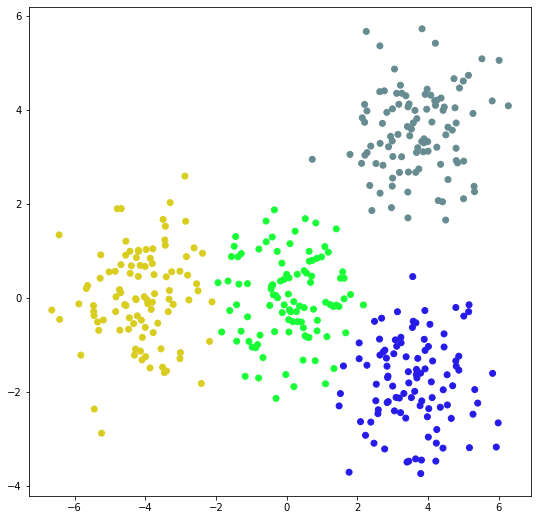

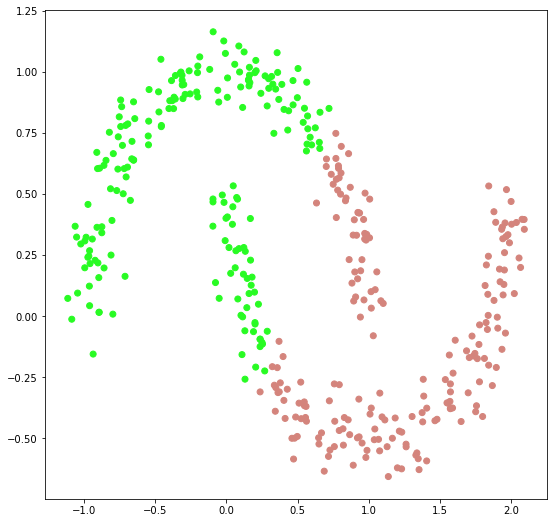

In [5]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

kmeans = KMeans(n_clusters=2)
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

### Задание 2 (2 балла)
В отличии от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Возможные метрики
* `euclidean`
* `manhattan`
* `chebyshev`

__Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [6]:
class DBScan:
    def __init__(self, eps: float = 0.5, min_samples: int = 5,
                 leaf_size: int = 40, metric: str = "euclidean"):
        """

        Parameters
        ----------
        eps : float, min_samples : int
            Параметры для определения core samples.
            Core samples --- элементы, у которых в eps-окрестности есть
            хотя бы min_samples других точек.
        metric : str
            Метрика, используемая для вычисления расстояния между двумя точками.
            Один из трех вариантов:
            1. euclidean
            2. manhattan
            3. chebyshev
        leaf_size : int
            Минимальный размер листа для KDTree.

        """
        self.eps = eps
        self.min_samples = min_samples
        self.leaf_size = leaf_size
        self.metric = metric

    def fit_predict(self, X: np.array, y=None) -> np.array:
        """
        Кластеризует элементы из X,
        для каждого возвращает индекс соотв. кластера.
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit_predict обязаны принимать
            параметры X и y, даже если y не используется).
        Return
        ------
        labels : np.array
            Вектор индексов кластеров
            (Для каждой точки из X индекс соотв. кластера).

        """
        kdtree = KDTree(
            X,
            leaf_size=self.leaf_size,
            metric=self.metric
        )
        neighbors_list = kdtree.query_radius(X, r=self.eps)
        n_points = X.shape[0]
        n_neighbors = np.array([len(neighbors_list[i]) for i in range(n_points)])
        is_core = np.asarray(n_neighbors >= self.min_samples, dtype=np.uint8)
        labels = np.full(n_points, -1)
        n_clusters = 0

        for i in range(n_points):
            if is_core[i] and labels[i] == -1:
                labels[i] = n_clusters
                deque = collections.deque(neighbors_list[i])
                while deque:
                    point_num = deque.popleft()
                    if labels[point_num] != -1 or point_num == i:
                        continue
                    labels[point_num] = n_clusters
                    if is_core[point_num]:
                        deque.extend(neighbors_list[point_num])
                n_clusters += 1
        return labels

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

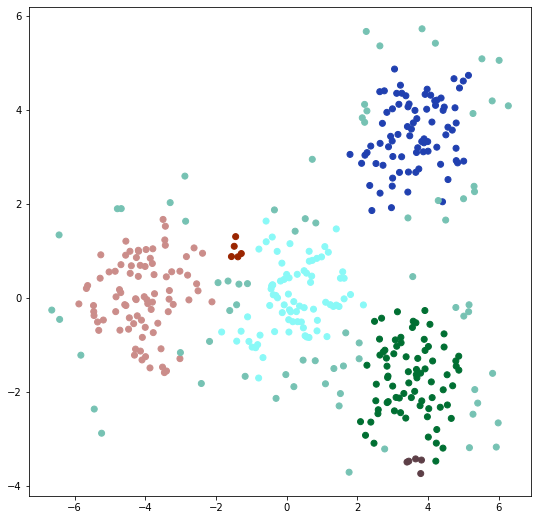

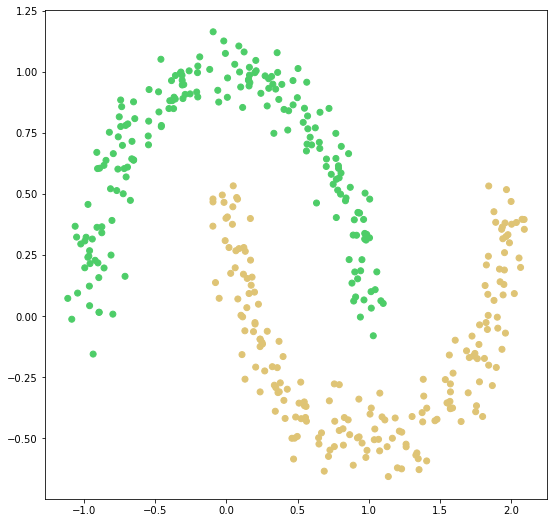

In [7]:
dbscan = DBScan()
labels = dbscan.fit_predict(X_1)
visualize_clasters(X_1, labels)

dbscan = DBScan(eps=0.2, min_samples=10)
labels = dbscan.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 3 (3 балла)
Идея AgglomerativeClustering заключается в том, чтобы итеративно объединять кластеры с наименьшим расстоянием между ними. Данный метод обладает высокой вычислительной сложностью, поэтому применим только для относительно небольших наборов данных.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Linkage-функции
__Linkage__ - это способ, которым будет рассчитываться расстояние между кластерами. Предлагается реализовать три варианта такой функции:
1. `average` - расстояние рассчитывается как среднее расстояние между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `single` - расстояние рассчитывается как минимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `complete` - расстояние рассчитывается как максимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.

In [8]:
class AgglomerativeClustering:
    def __init__(self, n_clusters: int = 16, linkage: str = "average"):
        """

        Parameters
        ----------
        n_clusters : int
            Количество кластеров, которые необходимо найти (то есть, кластеры
            итеративно объединяются, пока их не станет n_clusters)
        linkage : str
            Способ для расчета расстояния между кластерами. Один из 3 вариантов:
            1. average --- среднее расстояние между всеми парами точек,
               где одна принадлежит первому кластеру, а другая - второму.
            2. single --- минимальное из расстояний между всеми парами точек,
               где одна принадлежит первому кластеру, а другая - второму.
            3. complete --- максимальное из расстояний между всеми парами точек,
               где одна принадлежит первому кластеру, а другая - второму.
        """
        self.n_clusters = n_clusters
        self.linkage = linkage

    def fit_predict(self, X: np.array, y=None) -> np.array:
        """
        Кластеризует элементы из X,
        для каждого возвращает индекс соотв. кластера.
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit_predict обязаны принимать
            параметры X и y, даже если y не используется).
        Return
        ------
        labels : np.array
            Вектор индексов кластеров
            (Для каждой точки из X индекс соотв. кластера).

        """
        n_points = X.shape[0]
        labels = np.arange(n_points)
        distance = build_distance(X, X)
        distance[np.diag_indices(n_points)] = np.inf

        n_clusters_left = n_points
        while n_clusters_left > self.n_clusters:
            cluster_a, cluster_b = np.unravel_index(np.argmin(distance), shape=distance.shape)

            if self.linkage == "average":
                distance[cluster_a] = distance[:, cluster_a] = np.mean((distance[cluster_a], distance[cluster_b]),
                                                                       axis=0, keepdims=True)
            elif self.linkage == "single":
                distance[cluster_a] = distance[:, cluster_a] = np.minimum(distance[cluster_a], distance[cluster_b])
            elif self.linkage == "complete":
                distance[cluster_a] = distance[:, cluster_a] = np.maximum(distance[cluster_a], distance[cluster_b])

            distance[cluster_b] = distance[:, cluster_b] = distance[cluster_a, cluster_a] = np.inf
            labels[np.where(labels == cluster_b)] = cluster_a
            n_clusters_left = np.unique(labels).shape[0]

        real_labels = np.full(n_points, -1)
        real_cluster = 0
        for cluster in np.unique(labels):
            real_labels[np.where(labels == cluster)] = real_cluster
            real_cluster += 1
        return real_labels

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

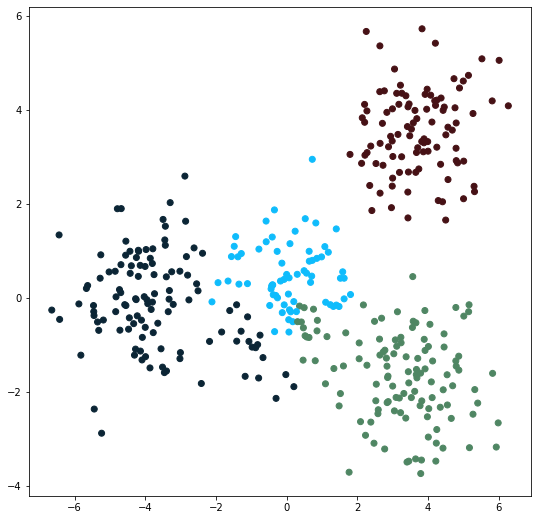

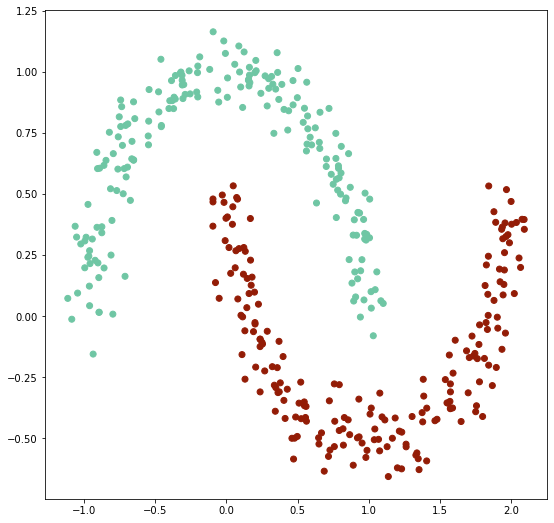

In [9]:
agg_clustering = AgglomerativeClustering(n_clusters=4)
labels = agg_clustering.fit_predict(X_1)
visualize_clasters(X_1, labels)

agg_clustering = AgglomerativeClustering(linkage="single", n_clusters=2)
labels = agg_clustering.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 4 (1 балл)
Реализуйте методы считывания и записи изображения при помощи библиотеки OpenCV. 

#### Описание методов
`read_image(path)` читает изображение и возвращает его в виде трехмерного numpy массива размера `(N, M, C)`, где `N` и `M` - размеры изображения, а `C` - количество цветов (3 для обычного изображения)
`save_image(image, path)` сохраняет изображение.

__Учтите, что `cv2.imread` считывает изображение в цветовой схеме BGR. После считывания необходимо перевести его в RGB и нормализовать__

In [10]:
def read_image(path: str) -> np.array:
    """
    Читает изображение.

    Parameters
    ----------
    path : str
        Путь к изображению.
    
    Return
    ------
    image : np.array
        Трехмерный массив размера (N, M, C), 
        где N и M - размеры изображения, 
        а C - количество цветов (3 для обычного изображения).
    """
    image = cv2.imread(path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def show_image(image: np.array) -> NoReturn:
    """
    Выводит изображение

    Parameters
    ----------
    image : np.array
        Трехмерный массив - нормализованное изображение в цветовой схеме RGB.
    """
    plt.figure(figsize=np.array(image.shape[:-1]) / 50)
    plt.imshow(image)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def save_image(image: np.array, path: str) -> NoReturn:
    """
    Сохраняет изображение.

    Parameters
    ----------
    image : np.array
        Трехмерный массив - нормализованное изображение в цветовой схеме RGB.
    path : str
        Путь для сохранения.
    """
    cv2.imwrite(path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

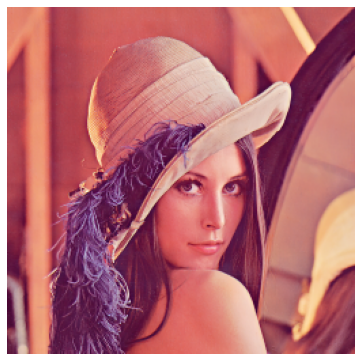

In [11]:
img = read_image("./image.png")
show_image(img)
# save_image(img, "./image1.png")

### Задание 5 (1 балл)
Реализуйте функцию, которая будет кластеризовать цвета изображения одним из реализованных алгоритмов. Интерфейс этой функции можно менять. Функция должна возвращать новое изображение, в котором цвета заменены на цвета кластеров.

Затем примените ее к цветам изображения.

__Примечание: это задание проще всего выполнить при помощи KMeans__

In [12]:
def clusterize_image(image, n_clusters=4):
    img_flatten = image.reshape(-1, image.shape[-1])
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++')
    kmeans.fit(img_flatten)
    clusters = kmeans.predict(img_flatten)
    recolored = img_flatten
    mean_colors = [np.mean(img_flatten[clusters == i], axis=0) for i in range(n_clusters)]

    for i in range(n_clusters):
        recolored[clusters == i] = mean_colors[i]
    
    recolored = recolored.reshape(image.shape)
    clusters_statistics(image.reshape(-1, 3) / 255,
                        np.array(mean_colors) / 255,
                        clusters)
    return recolored

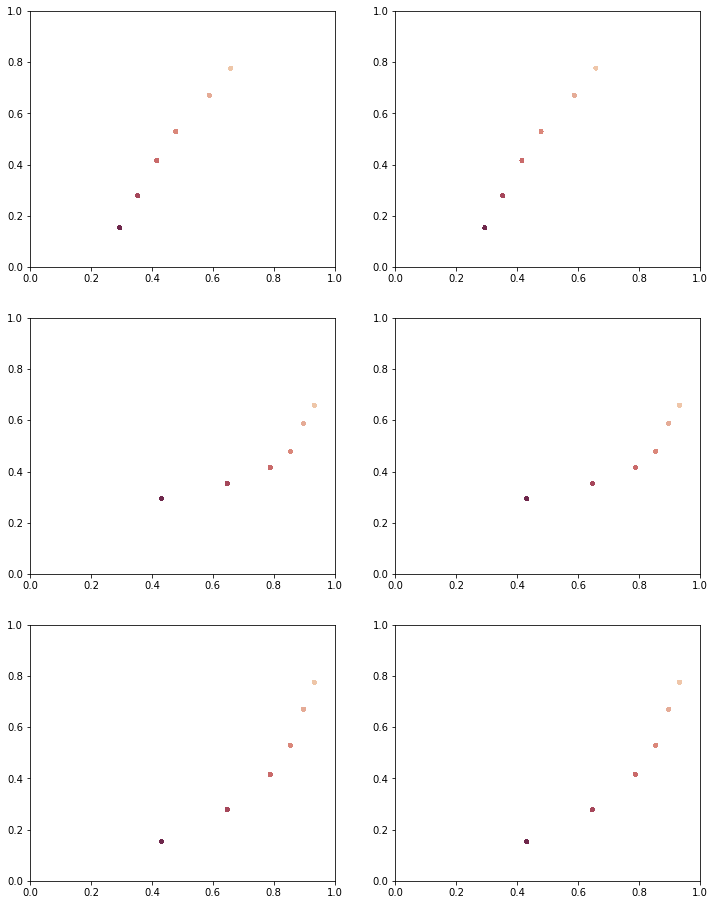

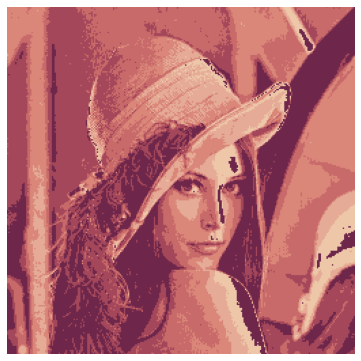

In [13]:
image = read_image("image.png")
result = clusterize_image(image, n_clusters=6)
show_image(result)
save_image(result, "result.png")